## Part 2: Supervised Baseline (Feedforward Network)
**Project**: FraudGuard - Credit Card Fraud Detection 

**Goal**: Train VAE and Apply Conformal predicitons.

In [77]:
import os
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, auc,
    roc_curve, precision_recall_curve
)

In [101]:
# ----------------------------
# Config
# ----------------------------
CSV_PATH = "creditcard.csv"   # <-- put your path here
RANDOM_STATE = 42

# Global split: main/calib/test
MAIN_FRAC  = 0.70
CALIB_FRAC = 0.10
TEST_FRAC  = 0.20

# VAE training split inside main-legit
VAE_VAL_FRAC = 0.20

# VAE hyperparams
BATCH_SIZE = 128
SCORE_BATCH_SIZE = 256
LR = 3e-4
WEIGHT_DECAY = 1e-5

EPOCHS = 40
PATIENCE = 20

latent_dims = [2, 4, 8]
betas = [0.5, 1.0]

PARAM_GRID = [{"latent_dim": ld, "beta": b} for ld in latent_dims for b in betas]


OUT_DIR = "outputs_vae_conformal"
os.makedirs(OUT_DIR, exist_ok=True)

# Reproducibility
def seed_everything(seed=RANDOM_STATE):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [102]:
# ----------------------------
# 1) Load + Split data
# ----------------------------
df = pd.read_csv(CSV_PATH)

y = df["Class"].astype(int).values
X = df.drop(columns=["Class"]).values.astype(np.float32)

n = len(df)
print(f"Loaded: n={n}, fraud_rate={y.mean():.5f}")

# Global split: D_main, D_calib, D_test (stratified)
test_size_temp = 1.0 - MAIN_FRAC
X_main, X_temp, y_main, y_temp = train_test_split(
    X, y, test_size=test_size_temp, stratify=y, random_state=RANDOM_STATE
)

# Split temp into calib and test
# temp fraction = CALIB_FRAC + TEST_FRAC
calib_in_temp = CALIB_FRAC / (CALIB_FRAC + TEST_FRAC)
X_calib, X_test, y_calib, y_test = train_test_split(
    X_temp, y_temp, test_size=(1.0 - calib_in_temp),
    stratify=y_temp, random_state=RANDOM_STATE
)

print("\nGlobal splits:")
print(f"  D_main : {len(X_main)} (fraud_rate={y_main.mean():.5f})")
print(f"  D_calib: {len(X_calib)} (fraud_rate={y_calib.mean():.5f})")
print(f"  D_test : {len(X_test)} (fraud_rate={y_test.mean():.5f})")

# For VAE: use only legitimate transactions from D_main
X_main_legit = X_main[y_main == 0]
print(f"\nD_main_legit: {len(X_main_legit)}")

X_train_vae, X_val_vae = train_test_split(
    X_main_legit, test_size=VAE_VAL_FRAC, random_state=RANDOM_STATE
)

# Calibration for conformal: ONLY legitimate from D_calib (by ground-truth label)
X_calib_legit = X_calib[y_calib == 0]
print(f"D_calib_legit (for CP): {len(X_calib_legit)}")

# Standardize using ONLY VAE train-legit to avoid any test leakage
scaler = StandardScaler()
scaler.fit(X_train_vae)

X_train_vae_s = scaler.transform(X_train_vae).astype(np.float32)
X_val_vae_s   = scaler.transform(X_val_vae).astype(np.float32)

X_calib_legit_s = scaler.transform(X_calib_legit).astype(np.float32)
X_test_s        = scaler.transform(X_test).astype(np.float32)


Loaded: n=284807, fraud_rate=0.00173

Global splits:
  D_main : 199364 (fraud_rate=0.00173)
  D_calib: 28480 (fraud_rate=0.00172)
  D_test : 56963 (fraud_rate=0.00174)

D_main_legit: 199020
D_calib_legit (for CP): 28431


In [103]:
# ----------------------------
# Torch Dataset / Loader
# ----------------------------
def data_loader(X, batch_size=BATCH_SIZE, shuffle=True):
    torch_loader = DataLoader(
        torch.tensor(X, dtype=torch.float32), 
        batch_size=batch_size, 
        shuffle=shuffle,
        num_workers=0, 
        pin_memory=(device.type == "cuda")
    )
    return torch_loader

train_loader = data_loader(X_train_vae_s, BATCH_SIZE)
val_loader = data_loader(X_val_vae_s, BATCH_SIZE)

In [104]:
# ----------------------------
# 2) VAE definition + training utilities
# ----------------------------
class VAE(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, dropout_p: float = 0.2):
        super().__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Vinay et al. style (for ~29 dims): input -> 20 -> 15 -> latent (symmetric decoder)
        h1, h2 = 32, 16

        # encoder
        self.enc_fc1 = nn.Linear(input_dim, h1)
        self.enc_bn1 = nn.BatchNorm1d(h1)
        self.enc_do1 = nn.Dropout(p=dropout_p)

        self.enc_fc2 = nn.Linear(h1, h2)
        self.enc_bn2 = nn.BatchNorm1d(h2)
        self.enc_do2 = nn.Dropout(p=dropout_p)

        self.fc_mu = nn.Linear(h2, latent_dim)
        self.fc_logvar = nn.Linear(h2, latent_dim)

        # decoder
        self.dec_fc1 = nn.Linear(latent_dim, h2)
        self.dec_bn1 = nn.BatchNorm1d(h2)

        self.dec_fc2 = nn.Linear(h2, h1)
        self.dec_bn2 = nn.BatchNorm1d(h1)

        self.dec_fc3 = nn.Linear(h1, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = self.enc_do1(h)
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        h = self.enc_do2(h)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.dec_bn1(self.dec_fc1(z)))
        h = F.relu(self.dec_bn2(self.dec_fc2(h)))
        return self.dec_fc3(h)  # linear for standardized continuous features

    def forward(self, x, deterministic: bool = False):
        mu, logvar = self.encode(x)
        z = mu if deterministic else self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


def vae_loss(recon, x, mu, logvar, beta=1.0):
    recon_loss = ((recon - x) ** 2).mean(dim=1).mean()  # per-sample mse -> mean
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total = recon_loss + beta * kl
    return total, recon_loss, kl


def eval_epoch(model, loader, beta=1.0):
    with torch.no_grad():
        model.eval()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0
        for x in loader:
            x = x.to(device)
            recon, mu, logvar = model(x, deterministic=True)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta)
            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs
    return tot / n, rec / n, klv / n

In [105]:
def train_vae(model, train_loader, val_loader, epochs, lr, weight_decay, patience, beta=1.0):
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    history = {
        "train_total": [], "train_recon": [], "train_kl": [],
        "val_total": [], "val_recon": [], "val_kl": []
    }

    best_val_recon = float("inf")
    best_val_total = float("inf")
    best_state = None
    best_epoch = -1
    bad_epochs = 0

    warmup_epochs = 10  # KL warmup

    for epoch in tqdm(range(1, epochs + 1), desc="epochs", leave=True):
        model.train()
        tot, rec, klv, n = 0.0, 0.0, 0.0, 0

        beta_t = beta * min(1.0, epoch / warmup_epochs)

        for x in train_loader:
            x = x.to(device)
            optim.zero_grad(set_to_none=True)

            recon, mu, logvar = model(x)
            loss, rloss, kl = vae_loss(recon, x, mu, logvar, beta_t)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # clipping grad
            optim.step()

            bs = x.size(0)
            tot += loss.item() * bs
            rec += rloss.item() * bs
            klv += kl.item() * bs
            n += bs

        train_total = tot / n
        train_recon = rec / n
        train_kl = klv / n

        val_total, val_recon, val_kl = eval_epoch(model, val_loader, beta)

        history["train_total"].append(train_total)
        history["train_recon"].append(train_recon)
        history["train_kl"].append(train_kl)
        history["val_total"].append(val_total)
        history["val_recon"].append(val_recon)
        history["val_kl"].append(val_kl)
        
        if epoch == 1 or epoch % 3 == 0 or epoch == epochs:
            print(
                f"epoch {epoch:03d} | "
                f"train total={train_total:.3f} recon={train_recon:.3f} kl={train_kl:.3f} | "
                f"val total={val_total:.3f} recon={val_recon:.3f} kl={val_kl:.3f}"
            )

        # Early stopping criterion for grid search:
        # prioritize val_recon (since anomaly score uses recon MSE), tie-break with val_total
        improved = (val_recon < best_val_recon - 1e-7) or (
            abs(val_recon - best_val_recon) <= 1e-7 and val_total < best_val_total - 1e-7
        )
        if improved:
            best_val_recon = val_recon
            best_val_total = val_total
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping at epoch {epoch}. Best epoch: {best_epoch} (val_recon={best_val_recon:.3f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return history, best_epoch, best_val_recon, best_val_total

In [106]:
# ----------------------------
# 2b) Grid search (<= 5 runs)
# ----------------------------
input_dim = X_train_vae.shape[1]
best = None  # will store dict with model + params + stats

for i, cfg in enumerate(PARAM_GRID, start=1):
    seed_everything(RANDOM_STATE + i)  # stable but different init per config
    latent_dim = cfg["latent_dim"]
    beta = cfg["beta"]

    print(f"\n--- Config {i}/{len(PARAM_GRID)}: latent_dim={latent_dim}, beta={beta} ---") 
    model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)

    hist, be, val_recon_best, val_total_best = train_vae(
        model, train_loader, val_loader,
        beta=beta, epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, patience=PATIENCE
    )

    summary = {
        "cfg": cfg,
        "model_state": {k: v.detach().cpu().clone() for k, v in model.state_dict().items()},
        "history": hist,
        "best_epoch": be,
        "best_val_recon": val_recon_best,
        "best_val_total": val_total_best,
    }

    if best is None:
        best = summary
    else:
        # choose best by val_recon, tie-break with val_total
        improved = (summary["best_val_recon"] < best["best_val_recon"] - 1e-7) or (
            abs(summary["best_val_recon"] - best["best_val_recon"]) <= 1e-7 and
            summary["best_val_total"] < best["best_val_total"] - 1e-7
        )
        if improved:
            best = summary

print("\n====================")
print("Best config selected\n")
print(f"  latent_dim={best['cfg']['latent_dim']}, beta={best['cfg']['beta']}")
print(f"  best_epoch={best['best_epoch']}")
print(f"  best_val_recon={best['best_val_recon']:.3f}")
print(f"  best_val_total={best['best_val_total']:.3f}")

# Restore best model
vae = VAE(input_dim=input_dim, latent_dim=best["cfg"]["latent_dim"]).to(device)
vae.load_state_dict(best["model_state"])
history = best["history"]
BETA = best["cfg"]["beta"]



--- Config 1/6: latent_dim=2, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:09<06:21,  9.78s/it]

epoch 001 | train total=1.025 recon=1.004 kl=0.422 | val total=1.089 recon=0.984 kl=0.210


epochs:   8%|▊         | 3/40 [00:28<05:44,  9.31s/it]

epoch 003 | train total=0.984 recon=0.954 kl=0.198 | val total=1.041 recon=0.933 kl=0.217


epochs:  15%|█▌        | 6/40 [00:55<05:14,  9.24s/it]

epoch 006 | train total=0.986 recon=0.962 kl=0.079 | val total=1.010 recon=0.959 kl=0.101


epochs:  22%|██▎       | 9/40 [01:23<04:45,  9.20s/it]

epoch 009 | train total=0.987 recon=0.965 kl=0.047 | val total=1.002 recon=0.974 kl=0.056


epochs:  30%|███       | 12/40 [01:51<04:25,  9.47s/it]

epoch 012 | train total=0.985 recon=0.966 kl=0.038 | val total=1.006 recon=0.980 kl=0.052


epochs:  38%|███▊      | 15/40 [02:21<04:04,  9.77s/it]

epoch 015 | train total=0.984 recon=0.966 kl=0.035 | val total=1.001 recon=0.985 kl=0.032


epochs:  45%|████▌     | 18/40 [02:53<03:44, 10.21s/it]

epoch 018 | train total=0.982 recon=0.965 kl=0.034 | val total=1.011 recon=0.986 kl=0.051


epochs:  52%|█████▎    | 21/40 [03:26<03:24, 10.78s/it]

epoch 021 | train total=0.982 recon=0.966 kl=0.032 | val total=1.000 recon=0.990 kl=0.020


epochs:  55%|█████▌    | 22/40 [03:49<03:07, 10.44s/it]


Early stopping at epoch 23. Best epoch: 3 (val_recon=0.933)

--- Config 2/6: latent_dim=2, beta=1.0 ---


epochs:   2%|▎         | 1/40 [00:11<07:35, 11.68s/it]

epoch 001 | train total=1.012 recon=1.004 kl=0.082 | val total=1.109 recon=0.987 kl=0.122


epochs:   8%|▊         | 3/40 [00:34<07:10, 11.64s/it]

epoch 003 | train total=1.001 recon=0.995 kl=0.023 | val total=1.048 recon=0.994 kl=0.054


epochs:  15%|█▌        | 6/40 [01:10<06:36, 11.67s/it]

epoch 006 | train total=0.999 recon=0.994 kl=0.009 | val total=1.033 recon=0.991 kl=0.042


epochs:  22%|██▎       | 9/40 [01:45<06:04, 11.76s/it]

epoch 009 | train total=0.997 recon=0.990 kl=0.008 | val total=1.019 recon=0.995 kl=0.024


epochs:  30%|███       | 12/40 [02:19<05:17, 11.35s/it]

epoch 012 | train total=0.995 recon=0.988 kl=0.007 | val total=1.020 recon=0.999 kl=0.021


epochs:  38%|███▊      | 15/40 [02:51<04:37, 11.10s/it]

epoch 015 | train total=0.994 recon=0.986 kl=0.008 | val total=1.025 recon=1.005 kl=0.020


epochs:  45%|████▌     | 18/40 [03:24<04:00, 10.91s/it]

epoch 018 | train total=0.993 recon=0.986 kl=0.007 | val total=1.037 recon=1.015 kl=0.021


epochs:  50%|█████     | 20/40 [03:57<03:57, 11.85s/it]


epoch 021 | train total=0.992 recon=0.985 kl=0.007 | val total=1.027 recon=1.010 kl=0.017
Early stopping at epoch 21. Best epoch: 1 (val_recon=0.987)

--- Config 3/6: latent_dim=4, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:11<07:24, 11.39s/it]

epoch 001 | train total=0.979 recon=0.963 kl=0.323 | val total=1.105 recon=0.865 kl=0.478


epochs:   8%|▊         | 3/40 [00:34<07:09, 11.60s/it]

epoch 003 | train total=0.927 recon=0.865 kl=0.414 | val total=1.002 recon=0.821 kl=0.362


epochs:  15%|█▌        | 6/40 [01:08<06:28, 11.42s/it]

epoch 006 | train total=0.946 recon=0.876 kl=0.235 | val total=0.950 recon=0.841 kl=0.218


epochs:  22%|██▎       | 9/40 [01:42<05:45, 11.15s/it]

epoch 009 | train total=0.957 recon=0.899 kl=0.127 | val total=0.947 recon=0.880 kl=0.135


epochs:  30%|███       | 12/40 [02:14<05:07, 10.98s/it]

epoch 012 | train total=0.950 recon=0.906 kl=0.090 | val total=0.953 recon=0.898 kl=0.110


epochs:  38%|███▊      | 15/40 [02:47<04:31, 10.86s/it]

epoch 015 | train total=0.944 recon=0.902 kl=0.084 | val total=0.952 recon=0.902 kl=0.100


epochs:  45%|████▌     | 18/40 [03:18<03:54, 10.68s/it]

epoch 018 | train total=0.942 recon=0.903 kl=0.077 | val total=0.967 recon=0.919 kl=0.096


epochs:  52%|█████▎    | 21/40 [03:51<03:27, 10.91s/it]

epoch 021 | train total=0.938 recon=0.901 kl=0.072 | val total=0.961 recon=0.918 kl=0.085


epochs:  57%|█████▊    | 23/40 [04:26<03:16, 11.57s/it]


epoch 024 | train total=0.937 recon=0.902 kl=0.071 | val total=1.000 recon=0.947 kl=0.107
Early stopping at epoch 24. Best epoch: 4 (val_recon=0.810)

--- Config 4/6: latent_dim=4, beta=1.0 ---


epochs:   2%|▎         | 1/40 [00:11<07:35, 11.67s/it]

epoch 001 | train total=1.002 recon=0.986 kl=0.164 | val total=1.171 recon=0.921 kl=0.250


epochs:   8%|▊         | 3/40 [00:33<06:52, 11.16s/it]

epoch 003 | train total=0.976 recon=0.937 kl=0.130 | val total=1.058 recon=0.906 kl=0.151


epochs:  15%|█▌        | 6/40 [01:06<06:17, 11.09s/it]

epoch 006 | train total=0.981 recon=0.950 kl=0.051 | val total=0.996 recon=0.940 kl=0.056


epochs:  22%|██▎       | 9/40 [01:39<05:37, 10.89s/it]

epoch 009 | train total=0.982 recon=0.954 kl=0.031 | val total=0.990 recon=0.958 kl=0.032


epochs:  30%|███       | 12/40 [02:11<05:00, 10.72s/it]

epoch 012 | train total=0.981 recon=0.957 kl=0.024 | val total=1.001 recon=0.967 kl=0.034


epochs:  38%|███▊      | 15/40 [02:43<04:29, 10.79s/it]

epoch 015 | train total=0.980 recon=0.957 kl=0.023 | val total=1.001 recon=0.970 kl=0.031


epochs:  45%|████▌     | 18/40 [03:17<04:04, 11.12s/it]

epoch 018 | train total=0.977 recon=0.955 kl=0.021 | val total=1.006 recon=0.976 kl=0.030


epochs:  52%|█████▎    | 21/40 [03:53<03:40, 11.58s/it]

epoch 021 | train total=0.976 recon=0.954 kl=0.021 | val total=1.028 recon=0.995 kl=0.033


epochs:  55%|█████▌    | 22/40 [04:16<03:30, 11.67s/it]


Early stopping at epoch 23. Best epoch: 3 (val_recon=0.906)

--- Config 5/6: latent_dim=8, beta=0.5 ---


epochs:   2%|▎         | 1/40 [00:11<07:24, 11.40s/it]

epoch 001 | train total=0.973 recon=0.958 kl=0.311 | val total=1.082 recon=0.843 kl=0.477


epochs:   8%|▊         | 3/40 [00:34<07:01, 11.39s/it]

epoch 003 | train total=0.894 recon=0.829 kl=0.431 | val total=0.946 recon=0.747 kl=0.396


epochs:  15%|█▌        | 6/40 [01:07<06:19, 11.16s/it]

epoch 006 | train total=0.898 recon=0.811 kl=0.292 | val total=0.855 recon=0.714 kl=0.283


epochs:  22%|██▎       | 9/40 [01:40<05:42, 11.03s/it]

epoch 009 | train total=0.912 recon=0.819 kl=0.207 | val total=0.834 recon=0.742 kl=0.183


epochs:  30%|███       | 12/40 [02:12<05:01, 10.78s/it]

epoch 012 | train total=0.908 recon=0.824 kl=0.167 | val total=0.849 recon=0.770 kl=0.157


epochs:  38%|███▊      | 15/40 [02:44<04:27, 10.71s/it]

epoch 015 | train total=0.900 recon=0.820 kl=0.160 | val total=0.852 recon=0.779 kl=0.146


epochs:  45%|████▌     | 18/40 [03:17<04:03, 11.05s/it]

epoch 018 | train total=0.896 recon=0.818 kl=0.157 | val total=0.853 recon=0.775 kl=0.156


epochs:  52%|█████▎    | 21/40 [03:53<03:39, 11.57s/it]

epoch 021 | train total=0.891 recon=0.812 kl=0.158 | val total=0.853 recon=0.777 kl=0.152


epochs:  60%|██████    | 24/40 [04:27<03:03, 11.46s/it]

epoch 024 | train total=0.891 recon=0.812 kl=0.157 | val total=0.844 recon=0.768 kl=0.152


epochs:  62%|██████▎   | 25/40 [04:49<02:53, 11.60s/it]


Early stopping at epoch 26. Best epoch: 6 (val_recon=0.714)

--- Config 6/6: latent_dim=8, beta=1.0 ---


epochs:   2%|▎         | 1/40 [00:10<07:03, 10.85s/it]

epoch 001 | train total=0.991 recon=0.972 kl=0.190 | val total=1.155 recon=0.865 kl=0.290


epochs:   8%|▊         | 3/40 [00:32<06:44, 10.93s/it]

epoch 003 | train total=0.935 recon=0.873 kl=0.204 | val total=0.996 recon=0.814 kl=0.182


epochs:  15%|█▌        | 6/40 [01:05<06:07, 10.80s/it]

epoch 006 | train total=0.944 recon=0.876 kl=0.113 | val total=0.948 recon=0.836 kl=0.112


epochs:  22%|██▎       | 9/40 [01:36<05:30, 10.67s/it]

epoch 009 | train total=0.948 recon=0.893 kl=0.061 | val total=0.953 recon=0.891 kl=0.062


epochs:  30%|███       | 12/40 [02:08<04:59, 10.68s/it]

epoch 012 | train total=0.943 recon=0.902 kl=0.041 | val total=0.993 recon=0.937 kl=0.056


epochs:  38%|███▊      | 15/40 [02:43<04:40, 11.21s/it]

epoch 015 | train total=0.937 recon=0.900 kl=0.037 | val total=1.000 recon=0.948 kl=0.053


epochs:  45%|████▌     | 18/40 [03:18<04:13, 11.52s/it]

epoch 018 | train total=0.938 recon=0.901 kl=0.037 | val total=0.981 recon=0.937 kl=0.044


epochs:  52%|█████▎    | 21/40 [03:52<03:36, 11.40s/it]

epoch 021 | train total=0.935 recon=0.899 kl=0.035 | val total=0.968 recon=0.926 kl=0.042


epochs:  57%|█████▊    | 23/40 [04:25<03:16, 11.53s/it]

epoch 024 | train total=0.932 recon=0.896 kl=0.036 | val total=0.998 recon=0.949 kl=0.049
Early stopping at epoch 24. Best epoch: 4 (val_recon=0.803)

Best config selected

  latent_dim=8, beta=0.5
  best_epoch=6
  best_val_recon=0.714
  best_val_total=0.855



Saved loss plots:
  outputs_vae_conformal\vae_loss_total_train_vs_val.png
  outputs_vae_conformal\vae_loss_recon_train_vs_val.png


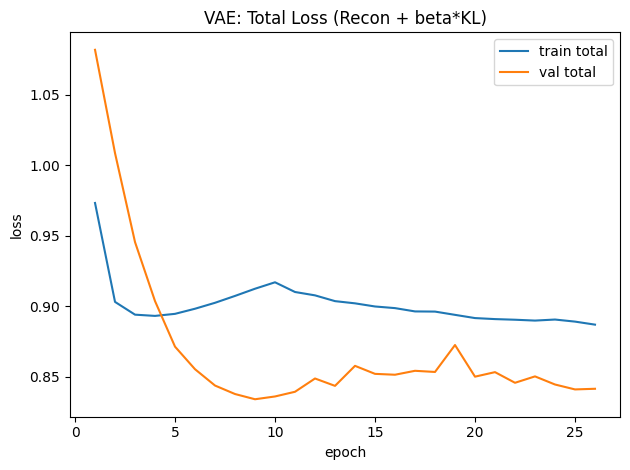

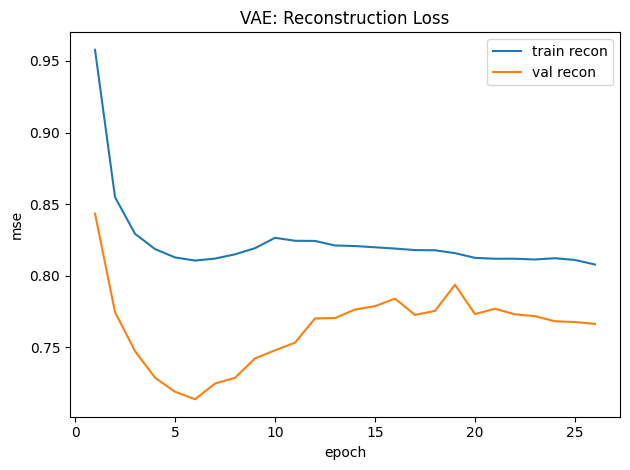

In [107]:
# ----------------------------
# Save 2 loss images for best run
# ----------------------------
epochs_r = np.arange(1, len(history["train_total"]) + 1)

plt.figure()
plt.plot(epochs_r, history["train_total"], label="train total")
plt.plot(epochs_r, history["val_total"], label="val total")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("VAE: Total Loss (Recon + beta*KL)")
plt.legend()
plt.tight_layout()
loss_total_path = os.path.join(OUT_DIR, "vae_loss_total_train_vs_val.png")
#plt.savefig(loss_total_path, dpi=200)
#plt.close()

plt.figure()
plt.plot(epochs_r, history["train_recon"], label="train recon")
plt.plot(epochs_r, history["val_recon"], label="val recon")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.title("VAE: Reconstruction Loss")
plt.legend()
plt.tight_layout()
loss_recon_path = os.path.join(OUT_DIR, "vae_loss_recon_train_vs_val.png")
#plt.savefig(loss_recon_path, dpi=200)
#plt.close()

print("\nSaved loss plots:")
print(f"  {loss_total_path}")
print(f"  {loss_recon_path}")


VAE score metrics on TEST (score = recon MSE):
  ROC-AUC = 0.932885
  PR-AUC  = 0.247123

Saved ROC/PR plots:
  outputs_vae_conformal\vae_roc_curve.png
  outputs_vae_conformal\vae_pr_curve.png


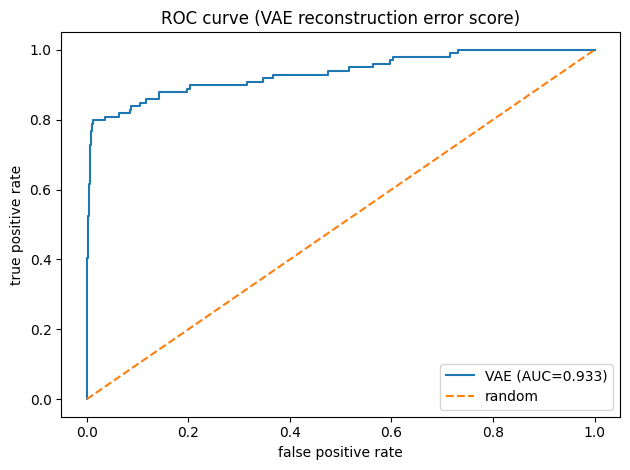

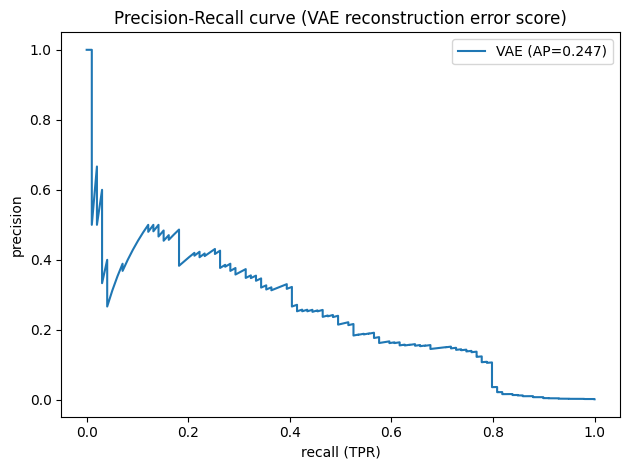

In [108]:
# ----------------------------
# Helper: compute VAE reconstruction error scores
# ----------------------------
def vae_scores_mse(model, X_np, batch_size=SCORE_BATCH_SIZE):
    with torch.no_grad():
        """Return per-sample reconstruction MSE scores."""
        model.eval()
        X_loaded = data_loader(X_np, batch_size=batch_size, shuffle=False)
        scores = []
        for x in X_loaded:
            x = x.to(device)
            recon, _, _ = model(x, deterministic=True)
            s = ((x - recon) ** 2).mean(dim=1)  # per-sample MSE
            scores.append(s.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

# ----------------------------
# 3) ROC-AUC + PR-AUC curves for VAE scores on TEST
# ----------------------------
scores_test = vae_scores_mse(vae, X_test_s)
roc_auc = roc_auc_score(y_test, scores_test)
pr_auc  = average_precision_score(y_test, scores_test)

print(f"\nVAE score metrics on TEST (score = recon MSE):")
print(f"  ROC-AUC = {roc_auc:.6f}")
print(f"  PR-AUC  = {pr_auc:.6f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, scores_test)
plt.figure()
plt.plot(fpr, tpr, label=f"VAE (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="random")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.title("ROC curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
roc_path = os.path.join(OUT_DIR, "vae_roc_curve.png")
#plt.savefig(roc_path, dpi=200)
#plt.close()

# PR curve
precision, recall, _ = precision_recall_curve(y_test, scores_test)
plt.figure()
plt.plot(recall, precision, label=f"VAE (AP={pr_auc:.3f})")
plt.xlabel("recall (TPR)")
plt.ylabel("precision")
plt.title("Precision-Recall curve (VAE reconstruction error score)")
plt.legend()
plt.tight_layout()
pr_path = os.path.join(OUT_DIR, "vae_pr_curve.png")
#plt.savefig(pr_path, dpi=200)
#plt.close()

print("\nSaved ROC/PR plots:")
print(f"  {roc_path}")
print(f"  {pr_path}")

## Conformal predictions

In [109]:
import numpy as np
import math

# ============================================================
# Conformal Outlier Detection (Section 6.3 of the article)
# Score: s(x) = MSE(x, x_hat)  (larger => more outlier)
# Calibrate on CLEAN data only (legit: y=0).
# Threshold: qhat = Quantile(s1..sn; ceil((n+1)(1-alpha))/n)
# Decision: outlier iff s(x) > qhat
# ============================================================

def conformal_outlier_threshold(scores_clean: np.ndarray, alpha: float) -> float:
    """
    Article (Sec 6.3): qhat = Quantile(s1..sn; ceil((n+1)(1-alpha))/n).
    Implemented as the k-th smallest score with k = ceil((n+1)(1-alpha)).
    """
    s = np.sort(np.asarray(scores_clean).reshape(-1))
    n = len(s)
    k = int(math.ceil((n + 1) * (1 - alpha)))
    k = min(max(k, 1), n)                   
    return float(s[k - 1])

def conformal_pvalues_upper_tail(scores_clean: np.ndarray, scores_x: np.ndarray) -> np.ndarray:
    """
    Conformal p-values for outlier detection (upper-tail):
    p(x) = (1 + #{i: s_i >= s(x)}) / (n + 1)
    Decision "outlier at level alpha" <=> p(x) <= alpha.
    """
    s = np.asarray(scores_clean).reshape(-1)
    t = np.asarray(scores_x).reshape(-1)
    n = len(s)
    
    # count how many calibration scores are >= each test score
    ge = (s[None, :] >= t[:, None]).sum(axis=1)
    return (1.0 + ge) / (n + 1.0)

# scores on CLEAN calibration set (legit only)
scores_calib_legit = vae_scores_mse(vae, X_calib_legit_s) 

# scores on test set (contains both classes; used only for evaluation)
scores_test = vae_scores_mse(vae, X_test_s)

alphas = [0.001, 0.01, 0.05, 0.1]
taus = {a: conformal_outlier_threshold(scores_calib_legit, a) for a in alphas}

print("Conformal outlier thresholds (calibrated on CLEAN legit only):")
for a in alphas:
    print(f"  alpha={a:.2%} -> qhat={taus[a]:.6f}")

def confusion_from_scores(y_true: np.ndarray, scores: np.ndarray, tau: float):
    y_pred = (scores > tau).astype(int)  # 1 = flagged as outlier/fraud
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fpr = fp / (fp + tn + 1e-12)
    tpr = tp / (tp + fn + 1e-12)
    return fpr, tpr, tn, fp, fn, tp

print("\nTest performance at conformal thresholds:")
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, tn, fp, fn, tp = confusion_from_scores(y_test, scores_test, tau)
    print(
        f"  alpha={a:.2%} | qhat={tau:.6f} | "
        f"FPR(test)={fpr_hat:.4%} | TPR(test)={tpr_hat:.4%} | "
        f"TN={tn} FP={fp} FN={fn} TP={tp}"
    )

Conformal outlier thresholds (calibrated on CLEAN legit only):
  alpha=0.10% -> qhat=18.255148
  alpha=1.00% -> qhat=3.269839
  alpha=5.00% -> qhat=1.369713
  alpha=10.00% -> qhat=1.060606

Test performance at conformal thresholds:
  alpha=0.10% | qhat=18.255148 | FPR(test)=0.1073% | TPR(test)=33.3333% | TN=56803 FP=61 FN=66 TP=33
  alpha=1.00% | qhat=3.269839 | FPR(test)=0.9127% | TPR(test)=76.7677% | TN=56345 FP=519 FN=23 TP=76
  alpha=5.00% | qhat=1.369713 | FPR(test)=5.0049% | TPR(test)=80.8081% | TN=54018 FP=2846 FN=19 TP=80
  alpha=10.00% | qhat=1.060606 | FPR(test)=9.8991% | TPR(test)=83.8384% | TN=51235 FP=5629 FN=16 TP=83


## Plots

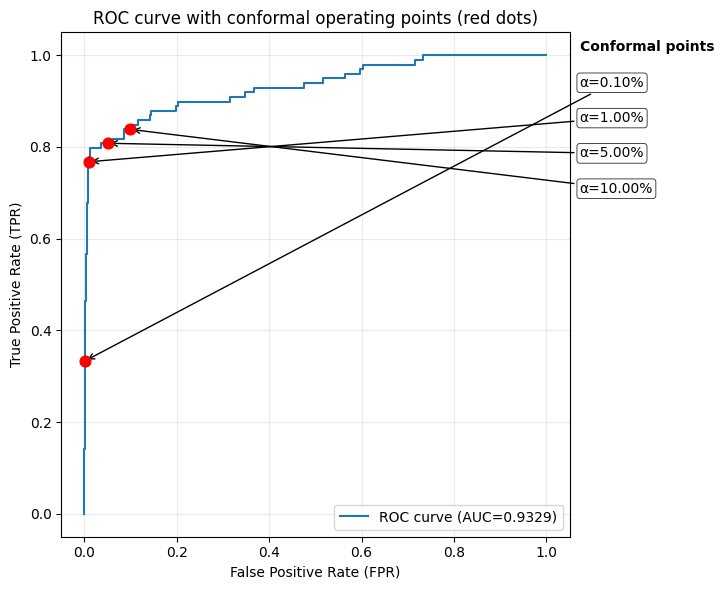

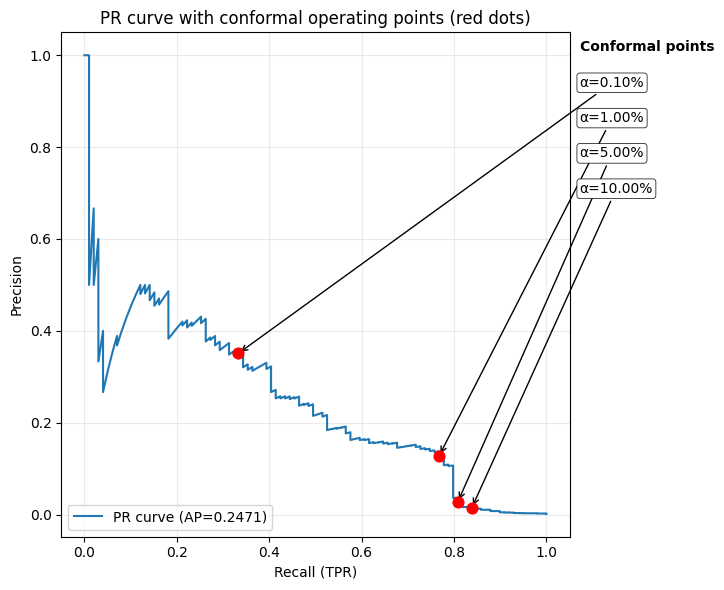

In [110]:
# Plot ROC/PR curves + conformal operating points
def confusion_rates_at_tau(y_true, scores, tau):
    """Decision rule: predict fraud/outlier if score > tau."""
    y_pred = (scores > tau).astype(int)

    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    fpr = fp / (fp + tn + 1e-12)
    tpr = tp / (tp + fn + 1e-12)
    precision = tp / (tp + fp + 1e-12)

    return fpr, tpr, precision, tn, fp, fn, tp


def add_annotation_legend_with_arrows(ax, points, title=None,
                                      x_text=1.02, y_top=0.90, y_step=0.07):
    """
    points: list of (label, x_pt, y_pt) in DATA coords.
    Places labels outside the right of the axes (axes fraction coords),
    draws arrows to corresponding data points.
    """
    if title is not None:
        ax.text(
            x_text, min(0.98, y_top + 0.07), title,
            transform=ax.transAxes, ha="left", va="center",
            fontsize=10, fontweight="bold", clip_on=False
        )

    for i, (lab, x_pt, y_pt) in enumerate(points):
        y_txt = y_top - i * y_step
        ax.annotate(
            lab,
            xy=(x_pt, y_pt), xycoords="data",
            xytext=(x_text, y_txt), textcoords="axes fraction",
            ha="left", va="center",
            arrowprops=dict(arrowstyle="->", lw=1.0),
            bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", lw=0.5),
            annotation_clip=False
        )


# ============================
# ROC curve
# ============================
fpr_curve, tpr_curve, _ = roc_curve(y_test, scores_test)
roc_auc = auc(fpr_curve, tpr_curve)

plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.plot(fpr_curve, tpr_curve, label=f"ROC curve (AUC={roc_auc:.4f})")

# conformal operating points (red dots)
roc_points = []
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, _, *_ = confusion_rates_at_tau(y_test, scores_test, tau)
    ax.scatter([fpr_hat], [tpr_hat], c="red", s=60, zorder=5)
    roc_points.append((f"α={a:.2%}", fpr_hat, tpr_hat))

# sort by x so arrows cross less
roc_points.sort(key=lambda t: t[1])

add_annotation_legend_with_arrows(
    ax, roc_points, title="Conformal points", x_text=1.02, y_top=0.90, y_step=0.07
)

ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("ROC curve with conformal operating points (red dots)")
ax.grid(True, alpha=0.25)
ax.legend(loc="lower right")

plt.tight_layout(rect=[0, 0, 0.82, 1])  # leave space on right for annotation legend
roc_path = os.path.join(OUT_DIR, "roc_with_conformal_operating_points.png")
#plt.savefig(roc_path, dpi=200, bbox_inches="tight")
#plt.close()


# ============================
# PR curve
# ============================
precision_curve, recall_curve, _ = precision_recall_curve(y_test, scores_test)
ap = average_precision_score(y_test, scores_test)

plt.figure(figsize=(9, 6))
ax = plt.gca()

ax.plot(recall_curve, precision_curve, label=f"PR curve (AP={ap:.4f})")

pr_points = []
for a in alphas:
    tau = taus[a]
    fpr_hat, tpr_hat, prec_hat, *_ = confusion_rates_at_tau(y_test, scores_test, tau)
    recall_hat = tpr_hat
    ax.scatter([recall_hat], [prec_hat], c="red", s=60, zorder=5)
    pr_points.append((f"α={a:.2%}", recall_hat, prec_hat))

pr_points.sort(key=lambda t: t[1])

add_annotation_legend_with_arrows(
    ax, pr_points, title="Conformal points", x_text=1.02, y_top=0.90, y_step=0.07
)

ax.set_xlabel("Recall (TPR)")
ax.set_ylabel("Precision")
ax.set_title("PR curve with conformal operating points (red dots)")
ax.grid(True, alpha=0.25)
ax.legend(loc="lower left")

plt.tight_layout(rect=[0, 0, 0.82, 1])
pr_path = os.path.join(OUT_DIR, "pr_with_conformal_operating_points.png")
#plt.savefig(pr_path, dpi=200, bbox_inches="tight")
#plt.close()